In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model, linear_model, naive_bayes, metrics, svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, scale
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import decomposition, ensemble
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
import xgboost as xgb


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# read data from excel


In [2]:
data = pd.read_csv('C:\MSC\ML\Data\TrainData.csv')
test_data = pd.read_csv('C:\MSC\ML\Data\TestData.csv',encoding = 'unicode_escape')

In [3]:
#train test split

In [4]:
train_x, valid_x, train_y, valid_y = train_test_split(data['Tweet text'], data['Label'])
test_x = test_data['Text']


0    1923
1    1911
Name: Label, dtype: int64


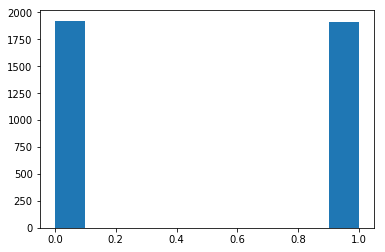

In [5]:
Target_table = data['Label'].value_counts()
print(Target_table)

plt.hist(data['Label'])
plt.show()


# create a count vectorizer object

In [6]:
############################################ create a count vectorizer object ##########################
def count_vect(data,train_x,valid_x,test_x):
    count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
    count_vect.fit(data)

    feature_vec = count_vect.transform(data)
    feature_vec = pd.DataFrame(feature_vec.toarray(), columns=count_vect.get_feature_names())


    # transform the training and testation data using count vectorizer object
    x_count_train =  count_vect.transform(train_x)
    x_count_valid =  count_vect.transform(valid_x)
    x_count_test = count_vect.transform(test_x)
    x_count_train = pd.DataFrame(x_count_train.toarray(), columns=count_vect.get_feature_names())
    x_count_valid = pd.DataFrame(x_count_valid.toarray(), columns=count_vect.get_feature_names())
    x_count_test = pd.DataFrame(x_count_test.toarray(), columns=count_vect.get_feature_names())

    return  feature_vec,x_count_train,x_count_valid, x_count_test


In [7]:

############################################ create a tf-idf object ###################################
def tfidf_count(data,train_x,valid_x,test_x,analy,ng_range):
   tfidf_vect = TfidfVectorizer(analyzer=analy, token_pattern=r'\w{1,}', max_features=5000,ngram_range=ng_range)
   tfidf_vect.fit(data)

   feature_vec =  tfidf_vect.transform(data)
   xtrain_tfidf =  tfidf_vect.transform(train_x)
   xvalid_tfidf =  tfidf_vect.transform(valid_x)
   xtest_tfidf =  tfidf_vect.transform(test_x)


   
   feature_vec = pd.DataFrame(feature_vec.toarray(), columns= tfidf_vect.get_feature_names())
   tfidf_train = pd.DataFrame(xtrain_tfidf.toarray(), columns=tfidf_vect.get_feature_names())
   tfidf_valid = pd.DataFrame(xvalid_tfidf.toarray(), columns=tfidf_vect.get_feature_names())
   tfidf_test = pd.DataFrame(xtest_tfidf.toarray(), columns=tfidf_vect.get_feature_names())

   return feature_vec,tfidf_train,tfidf_valid,tfidf_test


In [8]:
############################################ PCA ##################################################
def PCA_analysis(data,train,valid,test):
    pca = PCA(.95)
    pca.fit(data)
    pca_featurs = pca.transform(data)
    pca_featurs = pd.DataFrame(data)

    pca_trainx =  pca.transform(train)
    pca_validx =  pca.transform(valid)
    pca_testx =  pca.transform(test)


    #train_pca = pd.DataFrame(pca_trainx)
    #valid_pca = pd.DataFrame(pca_validx)
    #test_pca = pd.DataFrame(pca_testx)

    train_pca = pd.DataFrame(train)
    valid_pca = pd.DataFrame(valid)
    test_pca = pd.DataFrame(test)

    return train_pca,valid_pca,test_pca


In [9]:
######################## nb count vect ############################################
features,train,valid,test = count_vect(data['Tweet text'],train_x,valid_x,test_x)
train_x_count,valid_x_count,test_x_count = PCA_analysis(features,train,valid,test)


# Description of the data set

In [10]:
###############Description of the data set##########################################
x_count_train_df = train_x_count.copy()
word_count = pd.DataFrame(x_count_train_df.apply(sum,axis = 0)).reset_index()
word_count.columns = ['col_names','count']
word_count = word_count.sort_values(['count'],ascending = [False])


#dropping the zero count words
word_count = word_count[word_count['count']>0]

word_count.head(10)

,col_names,count
11035,the,1074
7864,not,1042
5439,i,1011
10802,t,994
11270,to,938
439,a,797
2419,co,714
5373,http,681
9607,sarcasm,606
5804,is,526


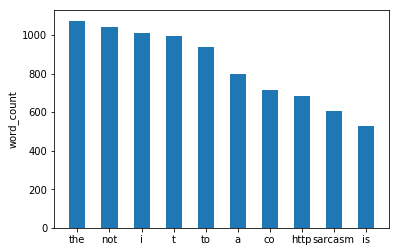

In [11]:
word_count = word_count.head(10)
plt.bar(np.arange(len(word_count)),word_count['count'],0.5)
plt.xticks(np.arange(len(word_count)), word_count['col_names'])
plt.ylabel('word_count')
plt.show()

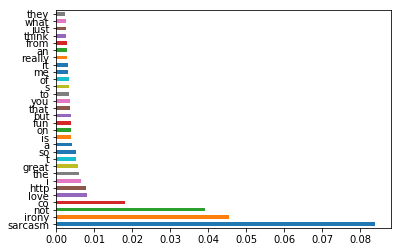

In [12]:
# Feature Importance
# fit an RFC model to the data
model = ensemble.RandomForestClassifier()
model.fit(train_x_count,train_y)
# display the relative importance of each attribute
importances_rf=pd.DataFrame(model.feature_importances_)
col=pd.DataFrame(np.array(train_x_count.columns))


feature_importances=pd.concat([col,importances_rf],axis=1)
feature_importances.columns=["feature","feature_importances.RF"]
feature_importances= feature_importances.sort_values(['feature_importances.RF'], ascending=False)
feature_importances=feature_importances.reset_index(drop=True)

top_features=feature_importances.feature.head(50)


(pd.Series(model.feature_importances_, index=train_x_count.columns)
   .nlargest(30)
   .plot(kind='barh')) 

plt.show()

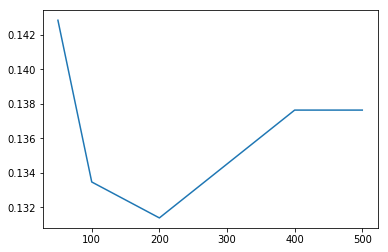

In [77]:
results=[]
n_estimator_options=[50,100,200,300,400,500]

for trees in n_estimator_options:
    model=ensemble.RandomForestClassifier(trees,random_state=1)
    model.fit(train_x_count,train_y)
    predict=model.predict(valid_x_count)
    err=1-model.score(valid_x_count,valid_y)
    results.append(err)


pd.Series(results,n_estimator_options).plot()
plt.show()

In [13]:
top_features=feature_importances.feature.head(30)
rf =ensemble.RandomForestClassifier(n_estimators=200,max_features="sqrt",max_depth=10,min_samples_leaf=5,criterion="gini")


rf.fit(train_x_count[top_features],train_y)

y_pred = rf.predict(valid_x_count[top_features].values)


print (pd.crosstab(index=valid_y, columns=y_pred, rownames=['actual'], colnames=['preds']))
print (metrics.classification_report(np.array(valid_y),y_pred))
print ("Overall Accuracy:", round(metrics.accuracy_score(np.array(valid_y),y_pred),2))




y_pred_vaild = pd.DataFrame( rf.predict(test_x_count[top_features].values))

y_pred_vaild = y_pred_vaild.reset_index()
y_pred_vaild.columns = ['Index','Label']
y_pred_vaild.to_csv('rf_count.csv', sep=',', index=False)

preds     0    1
actual          
0       417   84
1        21  437
             precision    recall  f1-score   support

          0       0.95      0.83      0.89       501
          1       0.84      0.95      0.89       458

avg / total       0.90      0.89      0.89       959

Overall Accuracy: 0.89


In [14]:
# Train Naive Bayes classifier

gnb = GaussianNB()
gnb.fit(train_x_count[top_features].values, train_y)
y_pred = gnb.predict(valid_x_count[top_features].values)

print (metrics.classification_report(np.array(valid_y),y_pred))
print ("Overall Accuracy:", round(metrics.accuracy_score(np.array(valid_y),y_pred),2))

y_pred_vaild = pd.DataFrame(gnb.predict(test_x_count[top_features].values))

y_pred_vaild = y_pred_vaild.reset_index()
y_pred_vaild.columns = ['Index','Label']
y_pred_vaild.to_csv('nb_count.csv', sep=',', index=False)


             precision    recall  f1-score   support

          0       0.77      0.87      0.82       501
          1       0.83      0.72      0.77       458

avg / total       0.80      0.80      0.79       959

Overall Accuracy: 0.8


In [15]:
#Train Logistic Regression 
top_features=feature_importances.feature.head(30)
linearclassifier = linear_model.LogisticRegression()  
linearclassifier.fit(train_x_count[top_features],train_y) 

y_pred = linearclassifier.predict(valid_x_count[top_features].values)


print (pd.crosstab(index=valid_y, columns=y_pred, rownames=['actual'], colnames=['preds']))
print (metrics.classification_report(np.array(valid_y),y_pred))
print ("Overall Accuracy:", round(metrics.accuracy_score(np.array(valid_y),y_pred),2))


preds     0    1
actual          
0       416   85
1        41  417
             precision    recall  f1-score   support

          0       0.91      0.83      0.87       501
          1       0.83      0.91      0.87       458

avg / total       0.87      0.87      0.87       959

Overall Accuracy: 0.87


In [18]:
from sklearn.svm import SVC  
top_features=feature_importances.feature.head(100)
svclassifier = SVC(kernel='sigmoid',C=10,gamma=1e-2)  
svclassifier.fit(train_x_count[top_features],train_y) 

y_pred = svclassifier.predict(valid_x_count[top_features].values)


print (pd.crosstab(index=valid_y, columns=y_pred, rownames=['actual'], colnames=['preds']))
print (metrics.classification_report(np.array(valid_y),y_pred))
print ("Overall Accuracy:", round(metrics.accuracy_score(np.array(valid_y),y_pred),2))


preds     0    1
actual          
0       358  143
1         1  457
             precision    recall  f1-score   support

          0       1.00      0.71      0.83       501
          1       0.76      1.00      0.86       458

avg / total       0.88      0.85      0.85       959

Overall Accuracy: 0.85


In [22]:
from xgboost import XGBClassifier
top_features=feature_importances.feature.head(50)
xgmodel = XGBClassifier(max_depth=10, n_estimators=30, learning_rate=0.1)
xgmodel.fit(train_x_count[top_features].values, train_y)

y_pred = xgmodel.predict(valid_x_count[top_features].values)


print (pd.crosstab(index=valid_y, columns=y_pred, rownames=['actual'], colnames=['preds']))
print (metrics.classification_report(np.array(valid_y),y_pred))
print ("Overall Accuracy:", round(metrics.accuracy_score(np.array(valid_y),y_pred),2))

preds     0    1
actual          
0       418   83
1        35  423
             precision    recall  f1-score   support

          0       0.92      0.83      0.88       501
          1       0.84      0.92      0.88       458

avg / total       0.88      0.88      0.88       959

Overall Accuracy: 0.88


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [23]:
def PCA_analysis(data,train,valid,test):
    pca = PCA(.95)
    pca.fit(data)
    pca_featurs = pca.transform(data)
    pca_featurs = pd.DataFrame(data)

    pca_trainx =  pca.transform(train)
    pca_validx =  pca.transform(valid)
    pca_testx =  pca.transform(test)


    train_pca = pd.DataFrame(pca_trainx)
    valid_pca = pd.DataFrame(pca_validx)
    test_pca = pd.DataFrame(pca_testx)

    #train_pca = pd.DataFrame(train)
    #valid_pca = pd.DataFrame(valid)
    #test_pca = pd.DataFrame(test)

    return train_pca,valid_pca,test_pca


# TFiDF count

In [24]:
################### TFiDF count###############################################################
features,train,valid,test = tfidf_count(data['Tweet text'],train_x,valid_x,test_x,'word',(1,1))
train_x_tfidf,valid_x_tfidf,test_x_tfidf = PCA_analysis(features,train,valid,test)

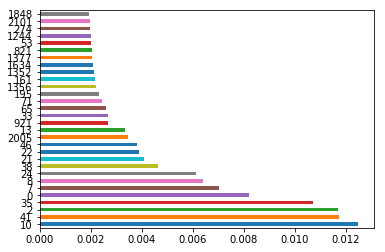

In [25]:
# Feature Importance
# fit an RFC model to the data
model = ensemble.RandomForestClassifier()
model.fit(train_x_tfidf,train_y)
# display the relative importance of each attribute
importances_rf=pd.DataFrame(model.feature_importances_)
col=pd.DataFrame(np.array(train_x_tfidf.columns))


feature_importances=pd.concat([col,importances_rf],axis=1)
feature_importances.columns=["feature","feature_importances.RF"]
feature_importances= feature_importances.sort_values(['feature_importances.RF'], ascending=False)
feature_importances=feature_importances.reset_index(drop=True)

top_features=feature_importances.feature.head(50)


(pd.Series(model.feature_importances_, index=train_x_tfidf.columns)
   .nlargest(30)
   .plot(kind='barh')) 

plt.show()


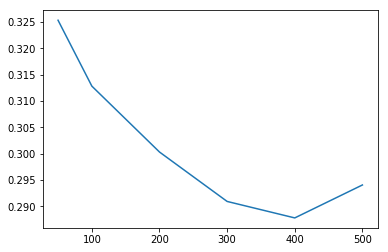

In [55]:
results=[]
n_estimator_options=[50,100,200,300,400,500]

for trees in n_estimator_options:
    model=ensemble.RandomForestClassifier(trees,random_state=1)
    model.fit(train_x_tfidf,train_y)
    predict=model.predict(valid_x_tfidf)
    err=1-model.score(valid_x_tfidf,valid_y)
    results.append(err)


pd.Series(results,n_estimator_options).plot()
plt.show()


In [27]:
top_features=feature_importances.feature.head(100)
rf =ensemble.RandomForestClassifier(n_estimators=400,max_features="sqrt",max_depth=10,min_samples_leaf=3,criterion="gini")


rf.fit(train_x_tfidf[top_features],train_y)

y_pred = rf.predict(valid_x_tfidf[top_features].values)


print (pd.crosstab(index=valid_y, columns=y_pred, rownames=['actual'], colnames=['preds']))


print (metrics.classification_report(np.array(valid_y),y_pred))
print ("Overall Accuracy:", round(metrics.accuracy_score(np.array(valid_y),y_pred),2))

y_pred_vaild = pd.DataFrame( rf.predict(test_x_tfidf[top_features].values))

y_pred_vaild = y_pred_vaild.reset_index()
y_pred_vaild.columns = ['Index','Label']
y_pred_vaild.to_csv('rf_tfidf.csv', sep=',', index=False)

preds     0    1
actual          
0       385  116
1        95  363
             precision    recall  f1-score   support

          0       0.80      0.77      0.78       501
          1       0.76      0.79      0.77       458

avg / total       0.78      0.78      0.78       959

Overall Accuracy: 0.78


In [ ]:
train_x['char_count'] = train_x['Tweet text'].apply(len)
train_x['word_count'] = train_x['Tweet text'].apply(lambda x: len(x.split()))
train_x['word_density'] = train_x['char_count'] / (train_x['word_count']+1)
train_x['punctuation_count'] = train_x['Tweet text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
train_x['title_word_count'] = train_x['Tweet text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
train_x['upper_case_word_count'] = train_x['Tweet text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

valid_x['char_count'] = valid_x['Tweet text'].apply(len)
valid_x['word_count'] = valid_x['Tweet text'].apply(lambda x: len(x.split()))
valid_x['word_density'] = valid_x['char_count'] / (valid_x['word_count']+1)
valid_x['punctuation_count'] = valid_x['Tweet text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
valid_x['title_word_count'] = valid_x['Tweet text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
valid_x['upper_case_word_count'] = valid_x['Tweet text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))



test_x['char_count'] = test_x['Text'].apply(len)
test_x['word_count'] = test_x['Text'].apply(lambda x: len(x.split()))
test_x['word_density'] = test_x['char_count'] / (test_x['word_count']+1)
test_x['punctuation_count'] = test_x['Text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
test_x['title_word_count'] = test_x['Text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
test_x['upper_case_word_count'] = test_x['Text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))